In [1]:
## 1 - Import Libraries
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

In [4]:
## 2 Display Settings

In [2]:
pd.set_option("display.max_columns",None)

In [3]:
sklearn.set_config(transform_output="pandas") # Normally output will be numpy array, if df needed

In [4]:
warnings.filterwarnings("ignore")

In [ ]:
## 3 - Read the Data

In [5]:
path = r"C:\Users\DELL\Desktop\PD\Flight Price Prediction\Data\train.csv"
train = pd.read_csv(path)

In [6]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-04-01,Kolkata,Banglore,21:10:00,08:15:00,665,1.0,In-flight meal not included,8849
1,Indigo,2019-05-24,Banglore,Delhi,13:00:00,15:50:00,170,0.0,No Info,4990
2,Jet Airways,2019-04-27,Banglore,Delhi,17:45:00,20:45:00,180,0.0,In-flight meal not included,4544
3,Air India,2019-05-06,Kolkata,Banglore,12:00:00,11:10:00,1390,2.0,No Info,10676
4,Indigo,2019-05-01,Kolkata,Banglore,19:20:00,23:45:00,265,1.0,No Info,3809
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-03-09,Mumbai,Hyderabad,06:30:00,08:00:00,90,0.0,In-flight meal not included,4995
636,Multiple Carriers,2019-03-06,Delhi,Cochin,06:00:00,15:30:00,570,1.0,No Info,15147
637,Indigo,2019-03-24,Chennai,Kolkata,07:55:00,10:15:00,140,0.0,No Info,4326
638,Air Asia,2019-03-24,Banglore,New Delhi,05:50:00,08:40:00,170,0.0,No Info,4284


In [7]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [8]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

In [ ]:
## 4 - Transformation Operations

In [9]:
## 4.1 - airline
X_train.airline

0            Jet Airways
1                 Indigo
2            Jet Airways
3              Air India
4                 Indigo
             ...        
635          Jet Airways
636    Multiple Carriers
637               Indigo
638             Air Asia
639          Jet Airways
Name: airline, Length: 640, dtype: object

In [10]:
air_transformer = Pipeline(steps=[
     ("imputer", SimpleImputer(strategy="most_frequent")),
     ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
     ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:,["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0
636,0.0,0.0,0.0,1.0,0.0
637,0.0,1.0,0.0,0.0,0.0
638,0.0,0.0,0.0,0.0,1.0


In [11]:
## date_of_journey
X_train.date_of_journey

0      2019-04-01
1      2019-05-24
2      2019-04-27
3      2019-05-06
4      2019-05-01
          ...    
635    2019-03-09
636    2019-03-06
637    2019-03-24
638    2019-03-24
639    2019-06-03
Name: date_of_journey, Length: 640, dtype: object

In [12]:
feature_to_extract = ["month","week", "day_of_week", "day_of_month"]

doj_transformer  = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
    ("scaler",MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_month
0,0.333333,0.294118,0.000000,0.000000
1,0.666667,0.705882,0.666667,0.884615
2,0.333333,0.470588,0.833333,1.000000
3,0.666667,0.588235,0.000000,0.192308
4,0.666667,0.529412,0.333333,0.000000
...,...,...,...,...
635,0.000000,0.058824,0.833333,0.307692
636,0.000000,0.058824,0.333333,0.192308
637,0.000000,0.176471,1.000000,0.884615
638,0.000000,0.176471,1.000000,0.884615


In [13]:
## 4.3 - Source and Destination
X_train.source

0       Kolkata
1      Banglore
2      Banglore
3       Kolkata
4       Kolkata
         ...   
635      Mumbai
636       Delhi
637     Chennai
638    Banglore
639       Delhi
Name: source, Length: 640, dtype: object

In [14]:
X_train.destination

0       Banglore
1          Delhi
2          Delhi
3       Banglore
4       Banglore
         ...    
635    Hyderabad
636       Cochin
637      Kolkata
638    New Delhi
639       Cochin
Name: destination, Length: 640, dtype: object

In [15]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Kolkata,Banglore
1,Banglore,Delhi
2,Banglore,Delhi
3,Kolkata,Banglore
4,Kolkata,Banglore
...,...,...
635,Mumbai,Hyderabad
636,Delhi,Cochin
637,Chennai,Kolkata
638,Banglore,New Delhi


In [16]:
location_pipe1 = Pipeline(steps=[
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", MeanEncoder()),
	("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,-0.109470,-0.121259
1,-0.824902,-1.807819
2,-0.824902,-1.807819
3,-0.109470,-0.121259
4,-0.109470,-0.121259
...,...,...
635,-1.862859,-0.740419
636,1.025846,1.023087
637,-1.862859,-0.740419
638,-0.824902,-0.740419


In [17]:
np.union1d(
	X_train.source.unique(),
	X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [18]:
def is_north(X):
	columns = X.columns.to_list()
	north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,0,1
2,0,1
3,1,0
4,1,0
...,...,...
635,1,0
636,1,0
637,0,1
638,0,1


In [19]:
location_transformer = FeatureUnion(transformer_list=[
	("part1", location_pipe1),
	("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,-0.109470,-0.121259,1,0
1,-0.824902,-1.807819,0,1
2,-0.824902,-1.807819,0,1
3,-0.109470,-0.121259,1,0
4,-0.109470,-0.121259,1,0
...,...,...,...,...
635,-1.862859,-0.740419,1,0
636,1.025846,1.023087,1,0
637,-1.862859,-0.740419,0,1
638,-0.824902,-0.740419,0,1


In [ ]:
## dep_time & arrival_time

In [20]:
X_train.dep_time

0      21:10:00
1      13:00:00
2      17:45:00
3      12:00:00
4      19:20:00
         ...   
635    06:30:00
636    06:00:00
637    07:55:00
638    05:50:00
639    16:00:00
Name: dep_time, Length: 640, dtype: object

In [21]:
X_train.arrival_time

0      08:15:00
1      15:50:00
2      20:45:00
3      11:10:00
4      23:45:00
         ...   
635    08:00:00
636    15:30:00
637    10:15:00
638    08:40:00
639    19:00:00
Name: arrival_time, Length: 640, dtype: object

In [22]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,21:10:00,08:15:00
1,13:00:00,15:50:00
2,17:45:00,20:45:00
3,12:00:00,11:10:00
4,19:20:00,23:45:00
...,...,...
635,06:30:00,08:00:00
636,06:00:00,15:30:00
637,07:55:00,10:15:00
638,05:50:00,08:40:00


In [23]:
time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
	("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.913043,0.181818,0.347826,0.272727
1,0.565217,0.000000,0.652174,0.909091
2,0.739130,0.818182,0.869565,0.818182
3,0.521739,0.000000,0.478261,0.181818
4,0.826087,0.363636,1.000000,0.818182
...,...,...,...,...
635,0.260870,0.545455,0.347826,0.000000
636,0.260870,0.000000,0.652174,0.545455
637,0.304348,1.000000,0.434783,0.272727
638,0.217391,0.909091,0.347826,0.727273


In [24]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,night,morning
1,afternoon,afternoon
2,evening,night
3,afternoon,morning
4,evening,night
...,...,...
635,morning,morning
636,morning,afternoon
637,morning,morning
638,morning,morning


In [25]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.179167,0.851064
1,0.000000,0.000000
2,0.220833,1.000000
3,0.000000,0.851064
4,0.220833,1.000000
...,...,...
635,1.000000,0.851064
636,1.000000,0.000000
637,1.000000,0.851064
638,1.000000,0.851064


In [26]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.913043,0.181818,0.347826,0.272727,0.179167,0.851064
1,0.565217,0.000000,0.652174,0.909091,0.000000,0.000000
2,0.739130,0.818182,0.869565,0.818182,0.220833,1.000000
3,0.521739,0.000000,0.478261,0.181818,0.000000,0.851064
4,0.826087,0.363636,1.000000,0.818182,0.220833,1.000000
...,...,...,...,...,...,...
635,0.260870,0.545455,0.347826,0.000000,1.000000,0.851064
636,0.260870,0.000000,0.652174,0.545455,1.000000,0.000000
637,0.304348,1.000000,0.434783,0.272727,1.000000,0.851064
638,0.217391,0.909091,0.347826,0.727273,1.000000,0.851064


In [ ]:
## duration

In [27]:
X_train.duration

0       665
1       170
2       180
3      1390
4       265
       ... 
635      90
636     570
637     140
638     170
639    1620
Name: duration, Length: 640, dtype: int64

In [28]:
(
	X_train
	.duration
	.quantile([0.25, 0.5, 0.75])
	.values
	.reshape(-1, 1)
	# .shape
)

array([[170. ],
       [472.5],
       [865. ]])

In [29]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [30]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.0,0.0,1.000000,1.000000
1,0.0,0.0,0.904837,0.904837
2,0.0,0.0,0.904837,0.904837
3,0.0,0.0,0.904837,0.904837
4,0.0,0.0,1.000000,1.000000
...,...,...,...,...
635,0.0,0.0,0.904837,0.904837
636,0.0,0.0,1.000000,1.000000
637,0.0,0.0,0.904837,0.904837
638,0.0,0.0,0.904837,0.904837


In [31]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [32]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [33]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.355970,-0.118046,-0.126442,2.0,0,0.132739
1,3.152322,-0.118046,-0.126442,0.0,0,-0.900216
2,-0.352902,-0.118046,-0.126442,1.0,0,-0.879348
3,-0.355970,-0.118046,-0.126442,2.0,1,1.645652
4,-0.355970,-0.118046,-0.126442,1.0,0,-0.701972
...,...,...,...,...,...,...
635,-0.355970,-0.118046,-0.126442,0.0,0,-1.067158
636,-0.355970,-0.118046,-0.126442,2.0,0,-0.065505
637,-0.355970,-0.118046,-0.126442,0.0,0,-0.962819
638,3.152322,-0.118046,-0.126442,0.0,0,-0.900216


In [ ]:
## total stops

In [34]:
X_train.total_stops

0      1.0
1      0.0
2      0.0
3      2.0
4      1.0
      ... 
635    0.0
636    1.0
637    0.0
638    0.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [35]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,0.0,1
2,0.0,1
3,2.0,0
4,1.0,0
...,...,...
635,0.0,1
636,1.0,0
637,0.0,1
638,0.0,1


In [ ]:
## additional info

In [36]:
X_train.additional_info

0      In-flight meal not included
1                          No Info
2      In-flight meal not included
3                          No Info
4                          No Info
                  ...             
635    In-flight meal not included
636                        No Info
637                        No Info
638                        No Info
639    In-flight meal not included
Name: additional_info, Length: 640, dtype: object

In [37]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,1.0,0.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [38]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [39]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [40]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,0.0,1.0,0.0,0
2,1.0,0.0,0.0,1
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,1.0,0.0,0.0,1
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


In [ ]:
## 5 - Colummn Transformer

In [41]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_month,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.333333,0.294118,0.000000,0.000000,-0.109470,-0.121259,1,0,0.913043,0.181818,0.347826,0.272727,0.179167,0.851064,-0.355970,-0.118046,-0.126442,2.0,0,0.132739,1.0,0,1.0,0.0,0.0,1
1,0.0,1.0,0.0,0.0,0.0,0.666667,0.705882,0.666667,0.884615,-0.824902,-1.807819,0,1,0.565217,0.000000,0.652174,0.909091,0.000000,0.000000,3.152322,-0.118046,-0.126442,0.0,0,-0.900216,0.0,1,0.0,1.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,0.333333,0.470588,0.833333,1.000000,-0.824902,-1.807819,0,1,0.739130,0.818182,0.869565,0.818182,0.220833,1.000000,-0.352902,-0.118046,-0.126442,1.0,0,-0.879348,0.0,1,1.0,0.0,0.0,1
3,1.0,0.0,0.0,0.0,0.0,0.666667,0.588235,0.000000,0.192308,-0.109470,-0.121259,1,0,0.521739,0.000000,0.478261,0.181818,0.000000,0.851064,-0.355970,-0.118046,-0.126442,2.0,1,1.645652,2.0,0,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0.0,0.0,0.666667,0.529412,0.333333,0.000000,-0.109470,-0.121259,1,0,0.826087,0.363636,1.000000,0.818182,0.220833,1.000000,-0.355970,-0.118046,-0.126442,1.0,0,-0.701972,1.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0,0.000000,0.058824,0.833333,0.307692,-1.862859,-0.740419,1,0,0.260870,0.545455,0.347826,0.000000,1.000000,0.851064,-0.355970,-0.118046,-0.126442,0.0,0,-1.067158,0.0,1,1.0,0.0,0.0,1
636,0.0,0.0,0.0,1.0,0.0,0.000000,0.058824,0.333333,0.192308,1.025846,1.023087,1,0,0.260870,0.000000,0.652174,0.545455,1.000000,0.000000,-0.355970,-0.118046,-0.126442,2.0,0,-0.065505,1.0,0,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0.0,0.0,0.000000,0.176471,1.000000,0.884615,-1.862859,-0.740419,0,1,0.304348,1.000000,0.434783,0.272727,1.000000,0.851064,-0.355970,-0.118046,-0.126442,0.0,0,-0.962819,0.0,1,0.0,1.0,0.0,0
638,0.0,0.0,0.0,0.0,1.0,0.000000,0.176471,1.000000,0.884615,-0.824902,-0.740419,0,1,0.217391,0.909091,0.347826,0.727273,1.000000,0.851064,3.152322,-0.118046,-0.126442,0.0,0,-0.900216,0.0,1,0.0,1.0,0.0,0


In [ ]:
## 6 - Feature Selection

In [42]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

In [ ]:
## 7 - Putting it all together

In [43]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.294118,-0.109470,-0.121259,-0.355970,2.0,0,0.132739,1.0,0
1,1.0,0.0,0.0,0.705882,-0.824902,-1.807819,3.152322,0.0,0,-0.900216,0.0,1
2,0.0,1.0,0.0,0.470588,-0.824902,-1.807819,-0.352902,1.0,0,-0.879348,0.0,1
3,0.0,0.0,0.0,0.588235,-0.109470,-0.121259,-0.355970,2.0,1,1.645652,2.0,0
4,1.0,0.0,0.0,0.529412,-0.109470,-0.121259,-0.355970,1.0,0,-0.701972,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.0,0.058824,-1.862859,-0.740419,-0.355970,0.0,0,-1.067158,0.0,1
636,0.0,0.0,0.0,0.058824,1.025846,1.023087,-0.355970,2.0,0,-0.065505,1.0,0
637,1.0,0.0,0.0,0.176471,-1.862859,-0.740419,-0.355970,0.0,0,-0.962819,0.0,1
638,0.0,0.0,1.0,0.176471,-0.824902,-0.740419,3.152322,0.0,0,-0.900216,0.0,1


In [ ]:
## 8 - viz

In [44]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': -0.013814601207213414,
 'air__airline_Indigo': 0.13506814390724173,
 'air__airline_Jet Airways': 0.21358981617378806,
 'air__airline_Multiple Carriers': 0.004106451243842087,
 'air__airline_Other': 0.11515755798089684,
 'doj__date_of_journey_month': 0.09265307257220756,
 'doj__date_of_journey_week': 0.18613487021870334,
 'doj__date_of_journey_day_of_week': -0.03379155197201267,
 'doj__date_of_journey_day_of_month': 0.022909174307616003,
 'location__source': 0.15161276831856776,
 'location__destination': 0.1505853157688131,
 'location__source_is_north': 0.020976174797272245,
 'location__destination_is_north': 0.020976174797272245,
 'time__dep_time_hour': -0.031971100591470535,
 'time__dep_time_minute': 0.027943890174889036,
 'time__arrival_time_hour': 0.07761160017696722,
 'time__arrival_time_minute': 0.025386732915405125,
 'time__dep_time_part_of_day': -0.02384726064129102,
 'time__arrival_time_part_of_day': 0.045597820321240455,
 'dur__duration_rbf_25': 0.11

In [45]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'doj__date_of_journey_day_of_week': -0.03379155197201267,
 'time__dep_time_hour': -0.031971100591470535,
 'time__dep_time_part_of_day': -0.02384726064129102,
 'dur__duration_rbf_75': -0.014984417061996824,
 'air__airline_Air India': -0.013814601207213414,
 'info__additional_info_In-flight meal not included': -0.013105151569528925,
 'info__additional_info_No Info': -0.009420181550535997,
 'info__additional_info': -0.009420181550535997,
 'dur__duration_rbf_50': -0.004906694030650398,
 'info__additional_info_Other': -0.0037358594920492427,
 'air__airline_Multiple Carriers': 0.004106451243842087,
 'location__source_is_north': 0.020976174797272245,
 'location__destination_is_north': 0.020976174797272245,
 'doj__date_of_journey_day_of_month': 0.022909174307616003,
 'time__arrival_time_minute': 0.025386732915405125,
 'time__dep_time_minute': 0.027943890174889036,
 'time__arrival_time_part_of_day': 0.045597820321240455,
 'time__arrival_time_hour': 0.07761160017696722,
 'doj__date_of_journey_m

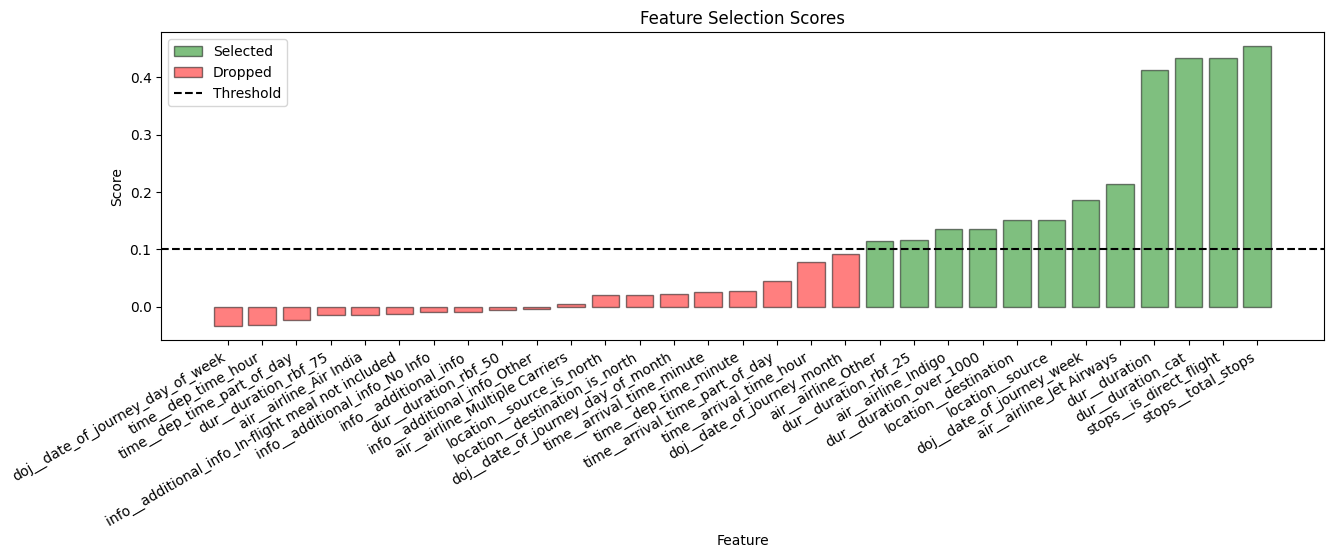

In [46]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()